In [144]:
# import diffeq_2 as methods
from scipy.integrate import odeint
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft, signal, linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import pandas as pd
# sns.set_theme()

from bvp import *


In [145]:
from pylab import rcParams
import mplcyberpunk
plt.style.use("cyberpunk")

# plt.style.use('ggplot')
rcParams['figure.figsize'] = 8, 5
rcParams['font.family'] = 'Pacifico'


## Strelska metoda

V in E morata biti normirana z predfaktorjem pred 2. odvodom Schrondingerjeve enacbe.

In [146]:
def equations_params(E, V): # kjer sta E in V normirana

    def equations(y0,x):
        psi, psi_x = y0
        f = np.array([psi_x, (V(x)-E)*psi ], dtype=np.float64)
        # f = np.array([x, f_2(theta)], dtype=np.float64)
        return f

    return equations

[ 1.          3.99999984  9.0000002  15.99999814 25.00000018 35.99999714]


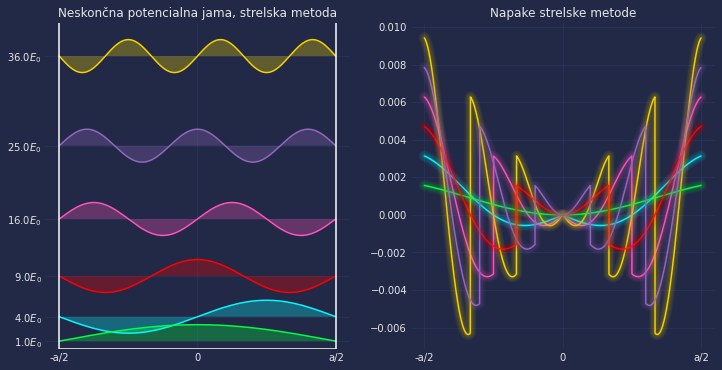

In [147]:
a = 1
E = 100

N = 3

def V(x):
    return 0 if np.abs(x)<=a/2 else np.inf

xs = np.linspace(0, a/2, 1000,endpoint=False)

def sode_psi(E):
    return odeint(equations_params(E, V), [1,0],  xs)[:, 0]

def liha_psi(E):
    return odeint(equations_params(E, V), [0,1],  xs)[:, 0]


def psi_exact_n(x, a, n):
    return np.sin(n*np.pi*x/a)

Es_lihe = []
Es_sode = []

i = 0
while len(Es_lihe) < N or i > 1e5:
    x1, x2 = i*10+1, (i+1)*10+1
    i += 1

    try:
        E = optimize.bisect(lambda x: liha_psi(x)[-1],x1,x2)
        Es_lihe.append(E)
    except:
        pass

    try:
        E = optimize.bisect(lambda x: sode_psi(x)[-1], x1, x2)
        Es_sode.append(E)
    except:
        pass
        

Es_lihe = np.array(Es_lihe)
Es_sode = np.array(Es_sode)

factor = 20

fig,ax = plt.subplots(1,2, figsize=(12,6))
ax1,ax2 = ax


# print(solved_psi[-1])
for n,E in enumerate(Es_lihe):
    y_r = odeint(equations_params(E, V), [0, 1],  xs)[:, 0]

    y = np.concatenate((-y_r[::-1], y_r))
    x = np.concatenate((-xs[::-1], xs))

    ax1.fill_between(x, y/np.max(y)*factor + E, E, alpha=0.3)
    ax1.plot(x, y/np.max(y)*factor + E)

    exact = psi_exact_n(x+0.5, a, 2*n+2)
    ax2.plot(x, np.abs(exact)-np.abs(y/np.max(y)))

for n,E in enumerate(Es_sode):
    y_r = odeint(equations_params(E, V), [1,0],  xs)[:, 0]

    y = np.concatenate((y_r[::-1], y_r))
    x = np.concatenate((-xs[::-1], xs))

    ax1.fill_between(x, y/np.max(y)*factor + E, E, alpha=0.3)
    ax1.plot(x, y/np.max(y)*factor + E)

    exact = psi_exact_n(x+0.5, a, 2*n+1)
    ax2.plot(x, np.abs(exact)-np.abs(y/np.max(y)))


allE = np.sort(np.concatenate((Es_lihe, Es_sode)))
print(allE/allE[0])

ax1.set_title("Neskončna potencialna jama, strelska metoda")

ax1.set_xticks([-a/2, 0, a/2])
ax1.set_xticklabels(['-a/2', '0', 'a/2'])
ax1.set_yticks(allE)
ax1.set_yticklabels([str(round(E/allE[0], 0))+'$E_0$' for E in allE])

V0 = 10000
ax1.plot([-a/2, -a/2, a/2, a/2], [V0, 0, 0, V0], 'white')
ax1.set_ylim([0, Es_lihe[-1]+2*factor])

ax2.set_xticks([-a/2, 0, a/2])
ax2.set_xticklabels(['-a/2', '0', 'a/2'])
ax2.set_title("Napake strelske metode")

mplcyberpunk.make_lines_glow()

plt.savefig('./grafi/neskoncna_potencialna_jama_strelska_metoda.pdf', bbox_inches='tight')
plt.show()

Iz grafa opazimo, da so napake precej majhne, lahko pa bi jih poljubno zmanjšal, če bi povečal število točk merjenja (uporabljam RK4, kar pomeni, da je napaka polinom stopnje 4), vendar v tem primeru ni tako važno (samo moj računalnik bi bolj trpel). Napaka na levi strani je relativna (in enaka relativni), ker sem funkcije najprej normiral z maksimumi.

## Končna jama

Najprej sem šel reševat z posameznimi funkcijami in enačil, da more biti odvod pri a/2 zvezen. To najdemo z bisekcijo drugega odvoda. Metoda je bila nenatančna, zato sem se odločil za implementacijo iz neskončnosti v neskončnost.

In [148]:
# a = 1
# # E = 100

# N = 1
# V0 = 100

# def V_k(x):
#     return 0 if np.abs(x)< a/2 else V0

# print(V_k(5))

# # xs = np.linspace(0, a/2, 100)
# step = 0.01
# xs = np.arange(0,a/2+2*step, step)

# def sode_psi(E):
#     return odeint(equations_params(E, V_k), [1,0],  xs)

# def liha_psi(E):
#     return odeint(equations_params(E, V_k), [0, 1],  xs)

# Es_lihe = []
# Es_sode = []

# def optimize_psi_liha(E):
#     psi = liha_psi(E)
#     return psi[-3, 1]-2*psi[-2, 1]+psi[-1, 1]

# def optimize_psi_soda(E):
#     psi = sode_psi(E)
#     return psi[-3, 1]-2*psi[-2, 1]+psi[-1, 1]

# i = 0
# while len(Es_lihe) < N and i < 1e1:
#     x1, x2 = i*10+1., (i+1)*10+1.
#     i += 1

#     try:
#         E = optimize.bisect(lambda x: optimize_psi_liha(x), x1, x2)
#         Es_lihe.append(E)
#     except Exception as e:
#         print(i,e)
#         pass

#     try:
#         E = optimize.bisect(lambda x: optimize_psi_soda(x)[-1], x1, x2)
#         Es_sode.append(E)
#     except:
#         pass

# print(Es_lihe,Es_sode)

# xs = np.arange(0, 3, step)

# E = Es_lihe[-1]
# psi = liha_psi(E)
# plt.plot(xs, liha_psi(E)[:, 1])
# print("psi", psi[-3, 1]-2*psi[-2, 1]+psi[-1, 1])

In [149]:
def vrednosti_graf(V0,N,factor, limit=1):
    def V_k(x):
        return 0 if np.abs(x) < a/2 else V0

    xs = np.linspace(-5,5,10000)


    def psi_E(E):
        return odeint(equations_params(E, V_k), [1e-6,0],  xs)[:, 0]

    Es = []

    i = 0
    while len(Es) < N and i < 1e4:
        x1, x2 = i*10+1., (i+1)*10+1.
        i += 1

        try:
            E = optimize.bisect(lambda x: psi_E(x)[-1], x1, x2)
            Es.append(E)
        except Exception as e:
            # print(i, e)
            pass

    Es = np.array(Es)
    print(Es/Es[0])

    for E in Es:
        # E = Es[0]

        max_E = np.max(
            np.abs(psi_E(E)[len(xs)//2-int(len(xs)*0.1):len(xs)//2+int(len(xs)*0.1)]))
        # print(max_E)

        # plt.plot(xs, psi_E(E)/max_E)
        y = psi_E(E)/max_E

        plt.plot(xs, y*factor + E)
        plt.fill_between(xs, y*factor + E, E, alpha=0.3)


    plt.ylim(0-factor, Es[-1]+2*factor)
    plt.xlim([-limit,limit])

    plt.plot([-5, -a/2, -a/2, a/2, a/2, 5], [V0, V0, 0, 0, V0, V0], 'white')

    plt.xticks([-a,-a/2, 0, a/2,a], ['-a','-a/2', '0', 'a/2','a'])
    plt.yticks(Es, [str(round(E/Es[0], 1))+' E$_0$' for E in Es])
    # plt.title
    # np.average()
    plt.title(f'Končna potencialna jama strelska za $V_0 = {V0}$')

    plt.savefig(f"./grafi/koncna_jama_V0_{V0}.pdf")
    mplcyberpunk.make_lines_glow()

    plt.show()

[ 1.          3.96990921  8.79783538 15.16573976]


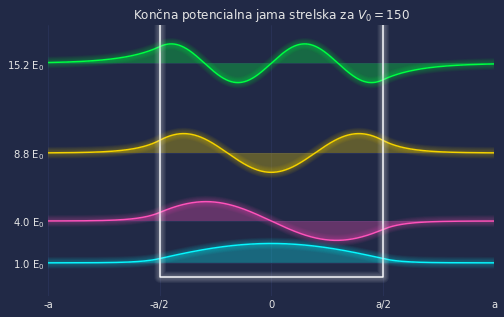

[ 1.          3.86668054  7.82490803 10.09920972]


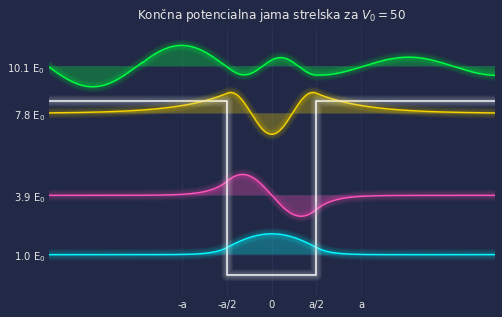

[ 1.          3.99788394  8.98706145 15.95566901]


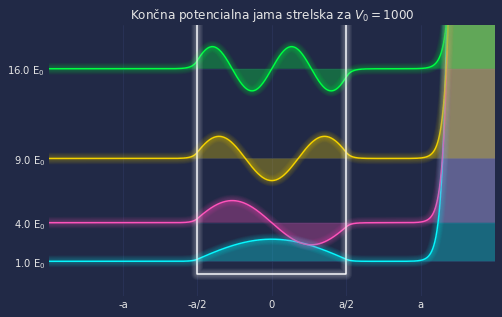

In [150]:
vrednosti_graf(150,4,10)
vrednosti_graf(50,4,6,limit=2.5)
vrednosti_graf(1000,4,15, limit=1.5)

Za implementacijo zgornjega grafa je šlo kar precej energije. Implementiral sem ga z opazovanjem robnih pogojev od -5 do 5. Potem z bisekcijo dobim tako energijo, da bo pri 5 čim bližje pogoju na levi strani. Kar je zelo problematično glede implementacije je, da vrednost pri 5 zmeraj divergira. Kar vbistvu bisekcija naredi. je, da poišče najmanjšo vrednost pri kateri dobimo pozitivno in negativno vrednost $-\infty$ in $\infty$ (kar je čisto pravilna energija).

Opazimo lahko tudi, da je za prosta stanja ($V_0 = 50$ in $n>4$) ni vseeno iz katere strani integriramo. Amplituda sinusa je namreč večja na levi kot na desni strani. Kar se tukaj zgodi iz smisla kvantne fizike je, da je primer vbistvu potencialna bariera, in se delci iz leve sipajo.

## Diferenčna metoda

In [151]:
# xs = np.linspace(0,a/2,50)

# E = -100

# plt.plot(xs,fd(0,E,0,xs,0,0))

[35.99896577 24.99950751 15.999803    8.9999409   3.99999015  1.        ]


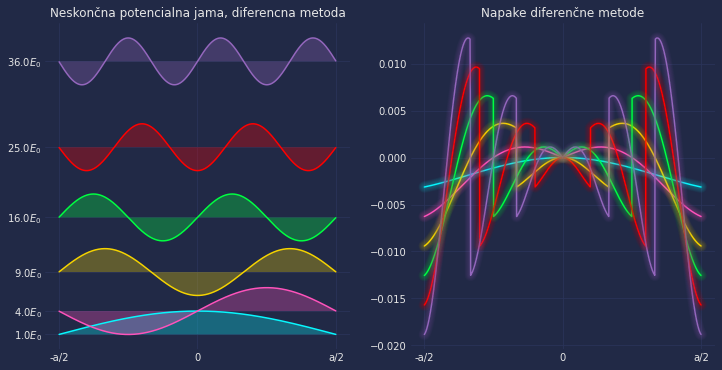

In [152]:
N = 1000
M = 6

# def tridiag(i,j):
#     if i==j:
#         return 2
#     elif i+1 == j or i-1 == j:
#         return 1
#     return 0

# tridiag_matrix = np.fromfunction(np.vectorize(tridiag), (N,N))
# tridiag_matrix

w,v = linalg.eigh_tridiagonal(np.ones(N)*-2, np.ones(N-1))

# plt.plot(v[:,-1])
print(w[-M:]/w[-1])


factor = 3

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = ax

for i in range(M):
    y = v[:, -i-1]
    x = np.linspace(-a/2,a/2,len(y))

    y /= np.max(y)

    E = w[-i-1]/w[-1]

    ax1.fill_between(x, y*factor + E, E, alpha=0.3)
    ax1.plot(x, y/np.max(y)*factor + E)

    exact = psi_exact_n(x+0.5, a, i+1)
    ax2.plot(x, np.abs(exact)-np.abs(y/np.max(y)))


ax1.set_title("Neskončna potencialna jama, diferencna metoda")

# allE = w[-M:]

allE = w[-M:]/w[-1]

ax1.set_xticks([-a/2, 0, a/2])
ax1.set_xticklabels(['-a/2', '0', 'a/2'])
ax1.set_yticks(allE)
ax1.set_yticklabels([str(round(E/allE[-1], 0))+'$E_0$' for E in allE])

V0 = 10000
# ax1.plot([-a/2, -a/2, a/2, a/2], [V0, 0, 0, V0], 'white')
# ax1.set_ylim([0, Es_lihe[-1]+2*factor])

ax2.set_xticks([-a/2, 0, a/2])
ax2.set_xticklabels(['-a/2', '0', 'a/2'])
ax2.set_title("Napake diferenčne metode")

mplcyberpunk.make_lines_glow()

plt.savefig('./grafi/neskoncna_potencialna_jama_diferencna_metoda.pdf',
            bbox_inches='tight')
plt.show()

In [153]:
N = 50
M = 6

def V_k(x):
    return 0 if np.abs(x) < a/2 else V0


x = np.linspace(-1,1,N)
V_x = np.array([V_k(xi) for xi in x])

print(V_x)


h = x[1] - x[0]

# d = np.ones(N)/h**2 + V(x)
# e = -np/ones(N-1)/2/h**2

w, v = linalg.eigh_tridiagonal(-2*np.ones(N) - 2*h**2*V_x, np.ones(N-1))

# plt.plot(v[:,-1])
print(w[-M:]/w[-1])

[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000]
[34.39168389 24.22989362 15.69056258  8.90684205  3.98443467  1.        ]


In [154]:
def vrednosti_graf(V0, factor, limit=1):
    N = 1000
    M = 6


    def V_k(x):
        return 0 if np.abs(x) < a/2 else V0


    x = np.linspace(-1, 1, N)
    V_x = np.array([V_k(xi) for xi in x])

    # print(V_x)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))


    ax1 = ax


    h = x[1] - x[0]

    # d = np.ones(N)/h**2 + V(x)
    # e = -np/ones(N-1)/2/h**2

    w, v = linalg.eigh_tridiagonal(-2*np.ones(N) - 2*h**2*V_x, np.ones(N-1))

    # plt.plot(v[:,-1])
    print(w[-M:]/w[-1])


    for i in range(M):
        y = v[:, -i-1]
        x = np.linspace(-a/2, a/2, len(y))

        y /= np.max(y)

        E = w[-i-1]/w[-1]

        ax1.fill_between(x, y*factor + E, E, alpha=0.3)
        ax1.plot(x, y/np.max(y)*factor + E)


    ax1.set_title(f"Končna potencialna jama, diferencna metoda, $V_0 = {V0}$")

    # allE = w[-M:]

    allE = w[-M:]/w[-1]

    ax1.set_xticks([-a/4, 0, a/4])
    ax1.set_xticklabels(['-a/2', '0', 'a/2'])
    ax1.set_yticks(allE)
    ax1.set_yticklabels([str(round(E/allE[-1], 0))+'$E_0$' for E in allE])

    # V0 = 10000
    # ax1.plot([-a/2, -a/2, a/2, a/2], [V0, 0, 0, V0], 'white')
    # ax1.set_ylim([0, Es_lihe[-1]+2*factor])


    mplcyberpunk.make_lines_glow()

    plt.savefig(f'./grafi/koncna_potencialna_jama_diferencna_metoda_V0_{V0}.pdf',bbox_inches='tight')
    plt.show()


[29.62750084 23.31940817 15.49002928  8.86783969  3.97977327  1.        ]


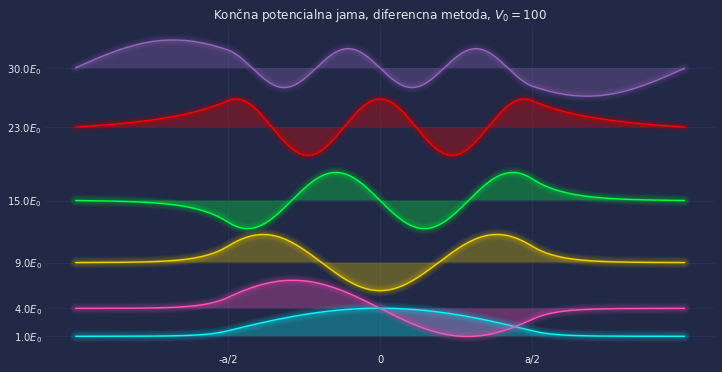

[21.03936838 18.60112907 14.33389481  8.63416318  3.9480752   1.        ]


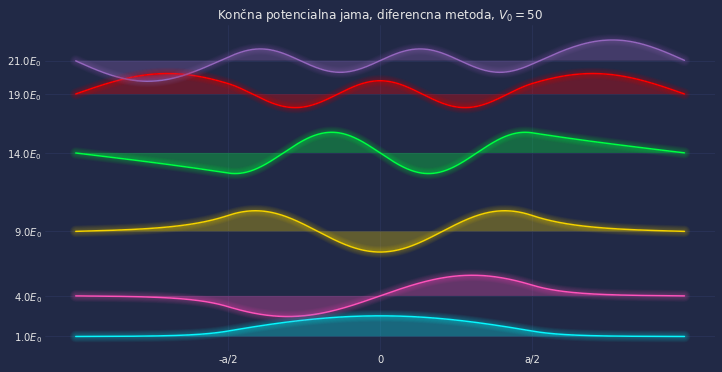

[35.90925681 24.95774544 15.98339405  8.99508432  3.99918834  1.        ]


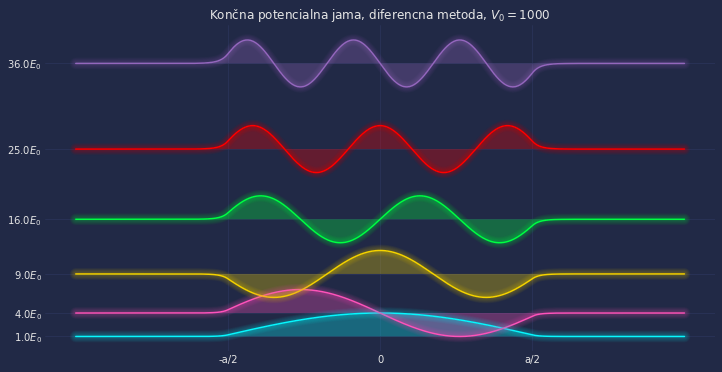

In [155]:
vrednosti_graf(100, 3)
vrednosti_graf(50, 1.5)
vrednosti_graf(1000, 3)

Precej lažje je rešiti homogen sistem, ko prestimo energijo navzgor. Dobimo enake grafe, kot smo jih dobili pri strelski metodi.